# Using JATIC's Object Detection Protocol with `xaitk-saliency`

This is a simple notebook demonstrating how detectors based on JATIC's object detection protocol can interface with `xaitk-saliency`.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Example Image](#example-image)
* [Instantiate Protocol-Based Detector](#instantiate-protocol-based-detector)
* [Transform Protocol-Based Detector](#transform-protocol-based-detector)
* [Use the Detector as "Normal"](#use-detector-as-normal)
    * [Get Detections](#get-detections)
    * [Generate Saliency Maps](#generate-saliency-maps)
        * [Prepare Inputs](#prepare-inputs)
        * [Saliency Generation](#saliency-generation)
        * [Display Saliency Maps](#display-saliency-maps)
    

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys

!{sys.executable} -m pip install -qU pip
print("Installing xaitk-jatic...")
!{sys.executable} -m pip install -q xaitk-jatic
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing timm...")
!{sys.executable} -m pip install -q timm
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip install -q torchvision
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Done!")

Installing xaitk-jatic...
Installing headless OpenCV...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing timm...
Installing torch...
Installing torchvision...
Installing matplotlib...
Done!


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.patches import Rectangle  # type: ignore

import numpy as np
import os
import time
import torch  # type: ignore
import urllib.request
from dataclasses import dataclass
from PIL import Image
from typing import Dict, Hashable, Sequence

from torchvision.transforms.functional import get_image_size  # type: ignore
from transformers import AutoModelForObjectDetection  # type: ignore
from transformers import AutoImageProcessor  # type: ignore

import maite.protocols.object_detection as od

from xaitk_jatic.interop.object_detection.model import JATICDetector
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import RandomGridStack

/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Example Image <a name="example-image"></a>

We'll use a single example image from the VisDrone test dataset.

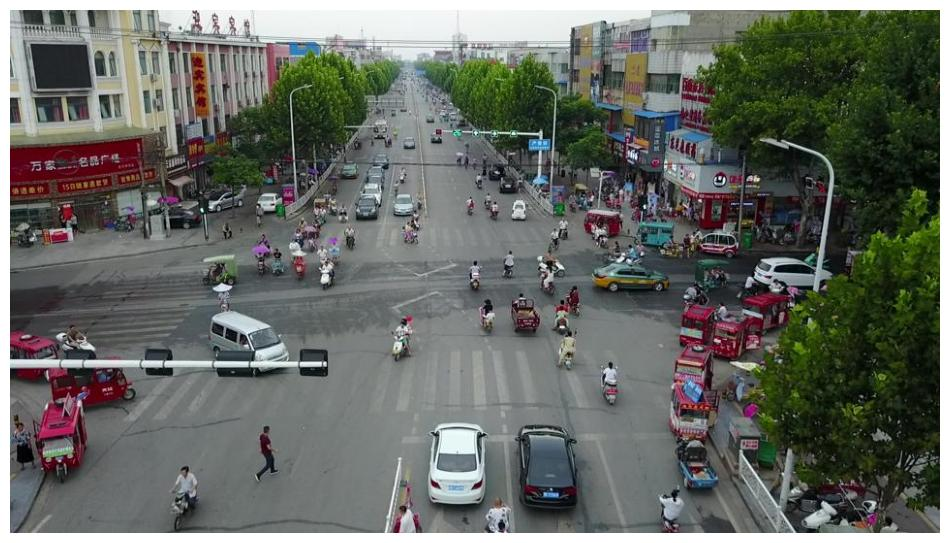

In [3]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

data_dir = "./data"
url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"

os.makedirs(data_dir, exist_ok=True)

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)

img = np.asarray(Image.open(img_path))

plt.figure(figsize=(12, 12))
plt.axis("off")
_ = plt.imshow(img)

We'll also define a function to display detections:

In [4]:
def show_dets(ax, dets, thresh=0.5, show_labels=False, show_ids=False):
    for i, det in enumerate(dets):
        score_dict = det[1]
        cls_name = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_name]

        if conf >= thresh:
            bbox = det[0]
            x_1, y_1 = bbox.min_vertex
            x_2, y_2 = bbox.max_vertex
            ax.add_patch(Rectangle((x_1, y_1), x_2 - x_1, y_2 - y_1, linewidth=1, edgecolor="r", facecolor="none"))

            labels = []
            if show_labels:
                labels.append(f"{cls_name} {conf:.2f}")
            if show_ids:
                labels.append(f"({i})")
            if labels:
                label = " ".join(labels)
                ax.text(x_1, y_1 - 2, label, color="b", fontsize=8)

## Instantiate Protocol-Based Detector <a name="instantiate-protocol-based-detector"></a>

First, we need a detector that uses the object detection protocol. Here we'll be be wrapping a model from Hugging Face, but this could be **any** model that conforms to the object detection protocol!

In [5]:
@dataclass
class DetectionTarget:
    boxes: torch.Tensor
    labels: torch.Tensor
    scores: torch.Tensor


class HuggingFaceDetector:
    def __init__(self, model_name: str, threshold: float, device: str):
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForObjectDetection.from_pretrained(model_name)
        self.threshold = threshold
        self.device = device

        self.model.eval()
        self.model.to(device)

    def id2label(self) -> Dict[int, Hashable]:
        return self.model.config.id2label

    def __call__(self, batch: od.InputBatchType) -> od.TargetBatchType:
        # tensor bridging
        input = torch.as_tensor(batch)
        assert input.ndim == 4

        # save original image sizes for resizing boxes
        target_sizes = [get_image_size(img)[::-1] for img in input]

        # preprocess
        hf_inputs = self.image_processor(input, return_tensors="pt")

        # put on device
        hf_inputs = hf_inputs.to(self.device)

        # get predictions
        with torch.no_grad():
            hf_predictions = self.model(**hf_inputs)
        hf_results = self.image_processor.post_process_object_detection(
            hf_predictions, threshold=self.threshold, target_sizes=target_sizes
        )

        predictions: od.TargetBatchType = list()
        for result in hf_results:
            predictions.append(
                DetectionTarget(
                    result["boxes"].detach().cpu(), result["labels"].detach().cpu(), result["scores"].detach().cpu()
                )
            )

        return predictions


model_name = "facebook/detr-resnet-50"
jatic_detector: od.Model = HuggingFaceDetector(
    model_name=model_name, threshold=0.5, device="cuda" if torch.cuda.is_available() else "cpu"
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Transform Protocol-Based Detector <a name="transform-protocol-based-detector"></a>

Now that we have our JATIC protocol-based detector, we can wrap it so that it can be used directly with `xaitk-saliency`.

In [6]:
detector = JATICDetector(detector=jatic_detector, id_to_name=jatic_detector.id2label(), img_batch_size=5)

## Use the Detector as "Normal" <a name="use-detector-as-normal"></a>

Now the detector can be used just like it is a regular `DetectImageObjects` implementation with `xaitk-saliency`.

### Get Detections <a name="get-detections"></a>

/tmp/ipykernel_1017817/3320407998.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  input = torch.as_tensor(batch)


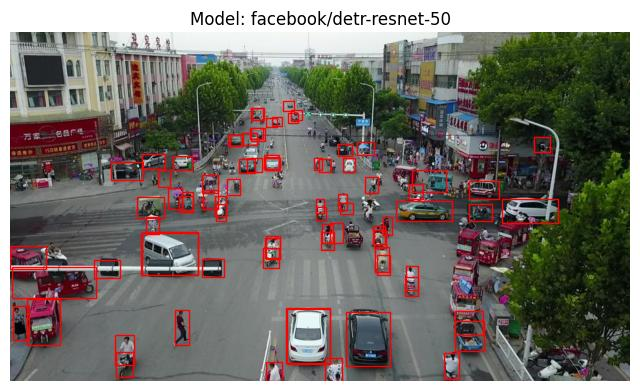

In [7]:
dets = list(detector([img]))[0]

# Display detections
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Model: {model_name}")  # type: ignore
axs.imshow(img)  # type: ignore
axs.axis("off")  # type: ignore
show_dets(axs, dets, thresh=0.4)

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

For the sake of this example, we have pre-selected four reference detections from the predictions made by the model to compute saliency maps. These are displayed below.

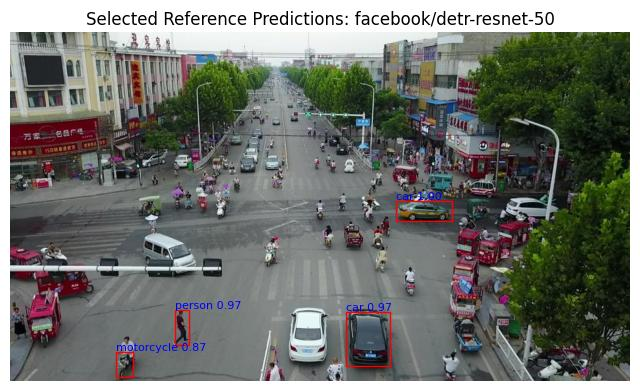

In [8]:
# indices of reference detections
centernet_idxs = [2, 74, 23, 73]
centernet_ref_dets = [list(dets)[idx] for idx in centernet_idxs]

fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Selected Reference Predictions: {model_name}")  # type: ignore
axs.imshow(img)  # type: ignore
axs.axis("off")  # type: ignore
show_dets(axs, centernet_ref_dets, thresh=0.4, show_labels=True)

#### Prepare Inputs <a name="prepare-inputs"></a>

The `GenerateObjectDetectorBlackboxSaliency` interface requires our reference detections to be split into separate bounding boxes and scores inputs, both as numpy arrays.

In [9]:
def dets_to_mats(dets):
    labels = [jatic_detector.id2label()[id] for id in sorted(jatic_detector.id2label().keys())]  # type: ignore

    bboxes = np.empty((0, 4))
    scores = np.empty((0, len(labels)))
    for det in dets:
        bbox = det[0]

        bboxes = np.vstack(
            (
                bboxes,
                [
                    *bbox.min_vertex,
                    *bbox.max_vertex,
                ],
            )
        )

        score_dict = det[1]
        score_array = []
        for l in labels:
            score_array.append(score_dict[l])

        scores = np.vstack(
            (
                scores,
                score_array,
            )
        )

    return bboxes, scores


centernet_bboxes, centernet_scores = dets_to_mats(centernet_ref_dets)

#### Saliency Generation <a name="saliency-generation"></a>

We'll use the `RandomGridStack` implementation to generate our saliency maps.

In [10]:
sal_generator = RandomGridStack(
    n=150,  # number of masks
    s=(7, 7),  # occlusion grid cell size in pixels
    p1=0.7,  # probability of not occluding cell
    threads=8,  # execution threads
    seed=42,  # seed for replicable results
)

# gray average of VisDrone
fill = [95, 96, 93]
sal_generator.fill = fill

In [11]:
print("Generating CenterNet saliency maps...")
start = time.time()
centernet_sal_maps = sal_generator(img, centernet_bboxes, centernet_scores, detector)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating CenterNet saliency maps...
Done in 198.45s


#### Display Saliency Maps <a name="display-saliency-maps"></a>

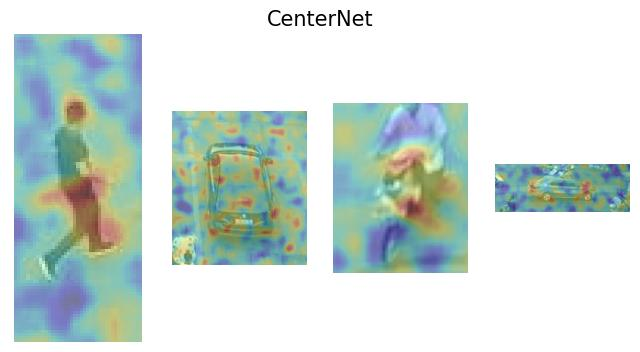

In [12]:
gray_img = np.asarray(Image.fromarray(img).convert("L"))
pad_perc = 0.4

n = len(centernet_sal_maps)

fig, axs = plt.subplots(1, n, figsize=(8, 4))

for i, ax in enumerate(axs):

    try:
        sal_map = centernet_sal_maps[i]
    except IndexError:
        ax.axis("off")
        continue

    x_1, y_1, x_2, y_2 = centernet_bboxes[i]
    pad_x = pad_perc * (x_2 - x_1)
    pad_y = pad_perc * (y_2 - y_1)
    x_1 = max(int(x_1 - pad_x), 0)
    y_1 = max(int(y_1 - pad_y), 0)
    x_2 = int(x_2 + pad_x)
    y_2 = int(y_2 + pad_y)

    img_crop = gray_img[y_1 : (y_2 + 1), x_1 : (x_2 + 1)]
    sal_crop = sal_map[y_1 : (y_2 + 1), x_1 : (x_2 + 1)]

    ax.imshow(img_crop, alpha=0.7, cmap="gray")
    ax.imshow(sal_crop, alpha=0.3, cmap="jet")
    ax.axis("off")

axs = fig.subplots()
axs.set_title("CenterNet", fontsize=15)  # type: ignore
_ = axs.axis("off")  # type: ignore